# How-To Guide into Feature Engineering  

## Introduction

If you haven't yet see the [overview posting] for this series, please take a minute to read that first...  Are you back?  Great.  Let's dive in.  

This post is going to delve into the mechanics of _feature engineering_ for the sorts of time series data that you may use as part of a stock price prediction modeling system.  I'll cover the basic concept, then offer some useful python code "recipes" for transforming your raw source data into features which can be fed directly into a ML algorithm or ML pipeline.

## Motivation

I believe (and I don't think I'm alone) that featue engineering is the most under-appreciated part of the art of machine learning.  It's certainly the most time consuming and tedious, but it's creative and "fun" (for those who like getting their hands dirty with data, anyway...).  

Feature engineering is also one of the key areas where those with domain expertise can shine.  Those whose expertise in investing is greater than their skill in machine learning will find that feature engineering will allow them to express that expertise.  

It is particularly important to making stock predictions.  All too often, I come across an online tutorial on forecasting stock prices which simply feed in daily returns (or worse, daily prices!) into a mind-blowingly complex algorithm and conclude that machine learning does not work for price prediction. 

Feature engineering is a term of art for data science and machine learning which refers to pre-processing and transforming raw data to distill it into a form which is more easily used by machine learning algorithms.  Much like chemical processing can extract pure gold from trace elements within ore, feature engineering can extract value from very noisy data.  

Anyone who has dabbled with any systems-based trading or charting already has experience with simple forms of feature engineering, whether or not they realized it.  For instance:
* Converting a series of asset prices into percent change values is a simple form of feature engineering
* Charting prices vs. a moving average is an implicit form of feature engineering
* Any technical indicator (RSI, MACD, etc...) are also forms of feature engineering

The process takes in one or more columns of "raw" input data (e.g., OHLC price data, 10-Q financials, social media sentiment, etc...) and converts it into _many_ columns of engineered features.   


## Words of Warning

Feature engineering is fundamentally a creative process.  As such, I believe there should be a minimum of rules or limits placed on it.  However, I do believe there are a few guidelines to be followed:  

* __No peeking:__ Peeking (into the future) is the original sin of feature engineering (and prediction modeling in general).  It refers to using information about the future (or information which would not yet be known by us...) to engineer a piece of data.  This can be obvious, like using next_12_months_returns.  However, it's most often quite subtle, like using the mean or standard deviation across the full time period to normalize data points (which implicitly leaks future information into our features.  The test is whether you would be able to get __the exact same value__ if you were calculating the data point at that point in time rather than today.  

* __Only the knowable:__ A corrolary to the above, you also need to be honest about what you would have known at the time, not just what had happened at the time.  For instance, short borrowing data is reported by exchanges with a considerable time lag.  You would want to stamp the feature with the date on which you _would have known_ it.  

* __Complete the table:__ Many machine learning algorithms expect that every input feature will have a value (of a certain type) for each observation.  If you envision a spreadsheet where each feature is a column and each observation is a row, there should be a value in each cell of the table.  Quite often, some features in the table will naturally update themselves more frequently than others.  Price data updates almost continuously, while short inventory, analyst estimates, or EBITDA tend to update every few weeks or months.  In these cases, we'll use a scheme like last observation carried forward (LOCF) to always have a value for each feature in the naturally lower frequency columns.  Of course, we will be careful to avoid inadvertent peeking!

* __Avoid false ordinality:__ Finally, it's extremely important to represent features in a way that captures ordinality only if it has meaning.  For instance, it's usually a bad idea to represent "day of the week" as an integer 1 to 7 since this implicitly tells the model to treat Friday as very similar to Thursday, but "a little more".  It would also say that Sunday and Monday are totally different (if Sunday =7 and Monday =1). We could miss all manner of interesting patterns in the data.  

## Getting Started
Let's dive in.  I will begin by extracting some toy data into a dataframe using free data from [quandl](https://www.quandl.com/): 

First, we'll make a utility function which downloads one or more symbols from quandl and returns the adjusted OHLC data (I generally find adjusted data to be best).

In [3]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like # remove once updated pandas-datareader issue is fixed
# https://github.com/pydata/pandas-datareader/issues/534
import pandas_datareader.data as web
%matplotlib inline

def get_symbols(symbols,data_source, begin_date=None,end_date=None):
    out = pd.DataFrame()
    for symbol in symbols:
        df = web.DataReader(symbol, data_source,begin_date, end_date)[['AdjOpen','AdjHigh','AdjLow','AdjClose','AdjVolume']].reset_index()
        df.columns = ['date','open','high','low','close','volume'] #my convention: always lowercase
        df['symbol'] = symbol # add a new column which contains the symbol so we can keep multiple symbols in the same dataframe
        df = df.set_index(['date','symbol'])
        out = pd.concat([out,df],axis=0) #stacks on top of previously collected data
    return out.sort_index()
        
prices = get_symbols(['AAPL','CSCO'],data_source='quandl',begin_date='2015-01-01',end_date='2017-01-01')



## TO BE COVERED
BASICS
* workflow from data to feature frame
* 

TECHNIQUES
* groupby
* rolling
* lambda

TRANSFORMS
* chg, pct chg
* MA/EMA, diffMA
* binning
* percentile (in peers, in rolling history)
* rank within peers
* one-hot
* Z-scores
* sign, sign if greater than...
* streak
* techincal indicators #https://github.com/bukosabino/ta
* calendar


DATA CLEANING
* to_datetime
* to_numeric
* missing fillna (ffill, mean w/peeking)
* 
    

With the data collected, we can create a new dataframe called "features" which will be used to compile all of the features we engineer.  Good practice is to create this dataframe with an index from your downloaded data, since you should only have new feature values as you have new primary source data.  

As the simple example below illustrates, we can then construct features from the data and store into multiple feature columns.  Note that there will often be null values inserted if the formula doesn't produce valid values for each row index.    


In [114]:
features = pd.DataFrame(index=prices.index).sort_index()
features['f01'] = prices.close/prices.open-1 # daily return
features['f02'] = prices.open/prices.groupby(level='symbol').close.shift(1)-1 # gap at open 
features.tail()


f01       f02
date       symbol                    
2016-12-28 CSCO   -0.009121  0.000652
2016-12-29 AAPL    0.002404 -0.002655
           CSCO    0.002963 -0.001644
2016-12-30 AAPL   -0.007115 -0.000685
           CSCO   -0.011126  0.003283

I favor following a bland naming convention like f01, f02, etc... for each feature (and then documenting what each feature represents...) rather than using descriptive column names.  My reasons for this are three-fold: (1) descriptive names tend to be long and cumbersome to use, (2) they're rarely truely self-describing, and (3) it's often useful to create an abstraction to conceal from the modeler (either yourself or someone else) what each represents.  Think of it like a blind taste test.

Following this basic code pattern, we can generate infinite flavors of features.  This is where your domain expertise and analytical creativity come into play!  My suggestion is to make sure you have a reasonable hypothesis before you create any feature, but don't be afraid to try many variations on a theme.  There is much to be learned from trying several flavors of feature transformations out.  


## Common Transforms
In the interest of accelerating your creativity, I've listed below a series of "recipes" for some of the transforms I've found useful - especially when using linear or quasi-linear models - extract meaningful relationships.   



### Logs
Many times, values like market cap, volume, revenue can map better to the prediction target if put into log space.  This is easy to do via pandas+numpy:

In [115]:
features['f03'] = prices.volume.apply(np.log) # log of daily volume

### Differencing
It's often more important to know how a value is changing than to know the value itself.  The `diff()` method will calculate the change in value since the prior period (i.e., current minus prior).  NOTE: the "groupby" is critically important since if it were omitted we would be comparing the difference in volume between symbols, which is not what we want.  

In [119]:
features['f03'] = prices.groupby(level='symbol').volume.diff() # change since prior day
features['f04'] = prices.groupby(level='symbol').volume.diff(50) # change since 50 days prior

### Rate of Change
Even more common is to want the rate of change as expressed by percent change.  Pandas has the handy `pct_change()` method for this purpose, but beware that you'll get odd behavior if you mix this with `groupby()` as shown above.  I prefer to create my own lambda wrapper function as shown below.

In [120]:
pct_chg_fxn = lambda x: x.pct_change()
features['f05'] = prices.groupby(level='symbol').volume.apply(pct_chg_fxn) # change since prior day

### Moving Averages
Sometimes, we'd rather use the moving average of a value as part of a feature.  This can be the value itself if you want to minimize how "jittery" a value is.  Or, more commonly, you may want to compare a value with a trailing moving average of itself.  

Again, we need to use groupby since our dataframe has info on multiple symbols - and again, we need to use a lambda function wrapper to avoid error.  There are other patterns which will accomplish the same thing but I find this to be cleanest.     

  

In [158]:
# log of 5 day moving average of volume
ma_5 = lambda x: x.rolling(5).mean()
features['f06'] = prices.volume.groupby(level='symbol').apply(ma_5).apply(np.log) 

# daily volume vs. 200 day moving average
ma_200 = lambda x: x.rolling(200).mean()
features['f07'] = prices.volume/ prices.volume.groupby(level='symbol').apply(ma_200)-1

# daily closing price vs. 50 day exponential moving avg
ema_50 = lambda x: x.ewm(span=50).mean()
features['f08'] = prices.close/ prices.close.groupby(level='symbol').apply(ema_50)-1




SIDE NOTE: Since the rolling window is an important - and somewhat arbitrary - value, you should try a range of reasonable values.  I have found that it's better to use an exponentially increasing range of values rather than a linear range.  In other words, use [5,10,20,40,80,160] rather than [10,20,30,40...,100].  The rationale is that values like 90 and 100 are really quite similar whereas 10 and 20 are quite different.  Therefore, if you choose linearly spaced values, you'll effectively be giving the higher end of the value range more chances to succeed than the lower values - and you'll increase the likelihood of overfitting a high value.  



### Z-Scores
A very popular/useful transformation for financial time series data is the [z-score](http://stattrek.com/statistics/dictionary.aspx?definition=z-score).  We can easily define a generalized lambda function for this, which we can use whenever needed.  Importantly, it allows us to mix together very different symbols (some high-beta, some low-beta) in a way that considers the statistical significance of any movement.  


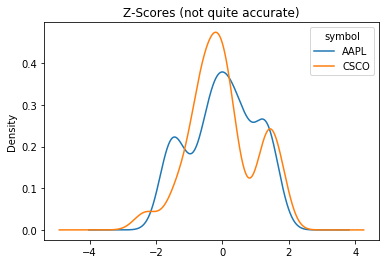

In [205]:
zscore_fxn = lambda x: (x - x.mean()) / x.std()
features['f09'] =prices.groupby(level='symbol').close.apply(zscore_fxn)
features.f09.unstack().plot.kde(title='Z-Scores (not quite accurate)')

However, the above example has a subtle but important bug.  It uses the mean _of the whole time frame_ and the standard deviation _of the whole time frame_ to calculate each datapoint.  This means we are peeking ahead into the future and the feature is potentially very danger-prone (it'll work famously well in sample and fail to work out of sample...).

Fixing this is cumbersome, but necessary.  

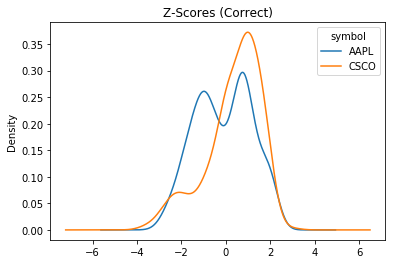

In [207]:
zscore_fun_improved = lambda x: (x - x.rolling(window=200, min_periods=20).mean())/ x.rolling(window=200, min_periods=20).std()
features['f10'] =prices.groupby(level='symbol').close.apply(zscore_fun_improved)
features.f10.unstack().plot.kde(title='Z-Scores (Correct)')

### Percentile
Less commonly used - but equally useful - is the percentile transformation.  Getting this done properly in pandas (with groupby and rolling) is possible but tricky.  The below example returns the percentile rank (from 0.00 to 1.00) of traded volume for each value as compared to a trailing 200 day period.  

Note that we need to use _a lambda within a lambda_ to make this work properly.  We're on the bleeding edge.


In [246]:
rollrank_fxn = lambda x: x.rolling(200,min_periods=20).apply(lambda x: pd.Series(x).rank(pct=True)[0],raw=True)
features['f11'] = prices.groupby(level='symbol').volume.apply(rollrank_fxn)

Another interesting application of this same pattern is to rank each stock _cross-sectionally_ rather than _longitudinally_ as above.  In other words, where does this stock rank within all of the stocks on that day, not for all prior days of that stock.  The below example isn't very meaningful with only two stocks, but quite useful when using a realistic universe.  In this example, we're also making use of an earlier feature (relative volume) to compare which symbol is most heavily traded _for that stock's normal range_ in a given day.  Also note that we need to `dropna()` prior to ranking because `rank` doesn't handle nulls very gracefully.   

In [256]:
features['f12'] = features['f07'].dropna().groupby(level='date').rank(pct=True) 


### Technical Indicators
Those with a taste for technical analysis may find it difficult to let go of your favored TA techniques.  While this is not _my_ favored approach, you'll have no problem engineering features using these methods.  From my cursory googling, it looked as though `ta` would be a good place to start.  Very new and only one contributor but it looks fairly complete and well documented.  If you find that it's missing your favorite indicators, consider contributing to the package.  If you know of better such packages, please post in the comments below...  

You may consider mean-centering a technical indicator so that machine learning methods can make better use of the data (or make sure to include that in the pre-processing pipeline when you start modeling).  


In [264]:
import ta # technical analysis library: https://technical-analysis-library-in-python.readthedocs.io/en/latest/
# money flow index (14 day)
features['f13'] = ta.momentum.money_flow_index(prices.high, prices.low, prices.close, prices.volume, n=14, fillna=False)
# mean-centered money flow index
features['f14'] = features['f13'] - features['f13'].rolling(200,min_periods=20).mean()


## Alternative Representations
A bit different than transforms are "representations", i.e., other ways to represent continuous values.  All of the transforms above returned continuous values rather than "labels", and that's often a good place to start - especally for early prototypes.

However, you may want to represent the data in different ways, especially if using classification-based approaches or worried about the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) due to large numbers of features.  

### Binning
We can easily convert a continous variable to discrete "bins" (like 1 to 10).  This loses information, of course, but sometimes loss of information is a good thing if you are removing more noise than signal.  

The below example shows volumes converted into ten equally sized buckets.  In other words, we've converted a continuous variable into a discrete one.  

NOTE: this example is not applied in a rolling fashion, so it __does suffer from some data peeking__, a cardinal sin.  At the moment, I'm failing in my efforts to implement it in a rolling way.  I'd be grateful for code snippets if anyone knows how to do this offhand.   

In [319]:
n_bins = 10
bin_fxn = lambda y: pd.qcut(y,q=n_bins,labels = range(1,n_bins+1))
features['f15'] = prices.volume.groupby(level='symbol').apply(bin_fxn)


### Signing
Very simply, you may wish to convert continuous variables into positive or negative (1 or -1) values, depending on input.  For instance, was volume increasing or decreasing today?  


In [322]:
features['f16'] = features['f05'].apply(np.sign)


### Plus-Minus
You may be interested in how many days in a row a value has increased (or decreased).  Below is a simple pattern to do just that - it calculates the number of up-days minus the number of down days.  


In [334]:
plus_minus_fxn = lambda x: x.rolling(20).sum()
features['f17'] = features['f16'].groupby(level='symbol').apply(plus_minus_fxn)

### One-Hot Encoding
Possibly the most necessary representation is "one-hot encoding" where a categorical variable is represented as a binary.  For instance, month_of_year would be represented as twelve different columns, each of which was either 0 or 1.  January would be [1,0,0,0,...0] etc...  

This is absolutely crucial in a few circumstances.  The first is where there is false meaning in the "ordinality" of values.  If we were looking to test the "santa claus effect" hypothesis, it wouldn't be helpful to use a month_of_year feature where January was "the least" and December was "the most".  

The second is in cases where we are representing events or "states".  Does the word "lawsuit" appear within the 10-Q footnotes?  Is the company in the blackout period for share buybacks?  

Finally, the particular machine learning algorithm (tree-based, neural networks) may find it easier to use binary representations than continuous or discrete ones.  

The below example creates twelve one-hot features, one for each month, and names them automatically 

In [371]:
month_of_year = prices.index.get_level_values(level='date').month
one_hot_frame = pd.DataFrame(pd.get_dummies(month_of_year))
one_hot_frame.index = prices.index # Careful!  This is forcing index values without usual pandas alignments!

# create column names 
begin_num = int(features.columns[-1][-2:]) + 1 #first available feature
feat_names = ['f'+str(num) for num in list(range(begin_num,begin_num+12,1))]

# rename columns and merge
one_hot_frame.columns = feat_names
features = features.join(one_hot_frame)


In [85]:
features = pd.DataFrame(index=prices.index)
features['volume_change_ratio'] = prices.groupby(level='symbol').volume.diff(1) / prices.groupby(level='symbol').shift(1).volume
features['momentum_5_day'] = prices.groupby(level='symbol').close.pct_change(5) 
features['intraday_chg'] = (prices.groupby(level='symbol').close.shift(0) - prices.groupby(level='symbol').open.shift(0))/prices.groupby(level='symbol').open.shift(0)
features['day_of_week'] = features.index.get_level_values('date').weekday
features['day_of_month'] = features.index.get_level_values('date').day
features.dropna(inplace=True)
features.tail(10)

volume_change_ratio  momentum_5_day  intraday_chg  \
date       symbol                                                      
2016-12-23 AAPL              -0.453747        0.004743      0.008046   
           CSCO              -0.291298       -0.001961     -0.000327   
2016-12-27 AAPL               0.284036        0.005316      0.006351   
           CSCO               0.546260       -0.002276      0.001305   
2016-12-28 AAPL               0.142595       -0.001625     -0.006467   
           CSCO              -0.151900       -0.004581     -0.009121   
2016-12-29 AAPL              -0.280609       -0.002819      0.002404   
           CSCO              -0.085396        0.001315      0.002963   
2016-12-30 AAPL               1.033726       -0.004042     -0.007115   
           CSCO               0.836194       -0.007879     -0.011126   

                   day_of_week  day_of_month  
date       symbol                             
2016-12-23 AAPL              4            23  
           CSCO              4            23  
2016-12-27 AAPL              1            27  
           CSCO              1            27  
2016-12-28 AAPL              2            28  
           CSCO              2            28  
2016-12-29 AAPL              3            29  
           CSCO              3            29  
2016-12-30 AAPL              4            30  
           CSCO              4            30

If the syntax or logic of the features isn't immediately clear, I'll cover that in more depth in [the next post].  For now, just note that we've created five features for both symbols using only data that would be available _as of the end of day T_.  

Also note that I've dropped any rows which contain any nulls for simplicity, since scikit-learn can't handle those out of the box.  

Next, we'll create outcomes:


In [86]:
outcomes = pd.DataFrame(index=prices.index)
# next day's opening change
outcomes['open_1'] = prices.groupby(level='symbol').open.shift(-1)/prices.groupby(level='symbol').close.shift(0)-1
# next day's closing change
outcomes['close_1'] = prices.groupby(level='symbol').close.pct_change(-1)
outcomes['close_5'] = prices.groupby(level='symbol').close.pct_change(-5)

(outcomes.tail(15))

open_1   close_1   close_5
date       symbol                              
2016-12-20 CSCO    0.004254  0.004602  0.004602
2016-12-21 AAPL   -0.006065  0.006621  0.002827
           CSCO   -0.000657 -0.001313 -0.001313
2016-12-22 AAPL   -0.006019 -0.001974  0.004058
           CSCO    0.002626 -0.002293  0.007942
2016-12-23 AAPL    0.000000 -0.006311       NaN
           CSCO    0.003603 -0.004889       NaN
2016-12-27 AAPL    0.002217  0.004282       NaN
           CSCO    0.000652  0.008547       NaN
2016-12-28 AAPL   -0.002655  0.000257       NaN
           CSCO   -0.001644 -0.001313       NaN
2016-12-29 AAPL   -0.000685  0.007857       NaN
           CSCO    0.003283  0.007942       NaN
2016-12-30 AAPL         NaN       NaN       NaN
           CSCO         NaN       NaN       NaN

Note that the shifted periods are negative, which in pandas convention looks _ahead_ in time.  This means that at the ending of our time period we will have nulls - and more nulls in the outcome colums that need to look further into the future.  We don't dropna() here since we may want to use `open_1` and there's no reason to throw away data from that column just because _a different_ outcome didn't have data.  But I digress.

Now, to put it together, we'll train a simple linear model in `scikit-learn`, using all features to predict `close_1` 

In [80]:

# first, create y (a series) and X (a dataframe), with only rows where 
# a valid value exists for both y and X
y = outcomes.close_1
X = features
Xy = X.join(y).dropna()
y = Xy[y.name]
X = Xy[X.columns]
print(y.shape)
print(X.shape)

(996,)
(996, 5)


Note that all of these slightly tedious steps have left us with properly sized, identically indexed data objects.  At this point, the modeling is dead simple:

In [81]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X,y)
print("Model RSQ: "+ str(model.score(X,y)))

print("Coefficients: ")
pd.Series(model.coef_,index=X.columns).sort_values(ascending=False)

Model RSQ: 0.01598347165537528
Coefficients: 


intraday_chg           0.150482
volume_change_ratio    0.000976
day_of_month           0.000036
day_of_week           -0.000427
momentum_5_day        -0.005543
dtype: float64

In [108]:
import numpy as np
arrays = [np.array([1,2,3,4,1,2,3,4]),np.array(['bar', 'bar', 'bar', 'bar', 'foo', 'foo', 'foo', 'foo'])]
s = pd.Series(np.array([100,101,102,103,200,201,202,203]), index=arrays)
s.name='values'
df = pd.DataFrame(s, index=arrays).sort_index()
df.index.names =['day','symbol']
print(df)

print(df.groupby(level='symbol').values.diff())

print(df.groupby(level='symbol').values.pct_change())

my_func = lambda x: x.pct_change()
print(df.groupby(level='symbol').values.apply(my_func))

print(df.groupby(level='symbol').values.diff() / df.groupby(level='symbol').values.shift(1))



            values
day symbol        
1   bar        100
    foo        200
2   bar        101
    foo        201
3   bar        102
    foo        202
4   bar        103
    foo        203
day  symbol
1    bar       NaN
     foo       NaN
2    bar       1.0
     foo       1.0
3    bar       1.0
     foo       1.0
4    bar       1.0
     foo       1.0
Name: values, dtype: float64
day  symbol
1    bar            NaN
     foo       1.000000
2    bar      -0.495000
     foo       0.990099
3    bar      -0.492537
     foo       0.980392
4    bar      -0.490099
     foo       0.970874
Name: values, dtype: float64
day  symbol
1    bar            NaN
     foo            NaN
2    bar       0.010000
     foo       0.005000
3    bar       0.009901
     foo       0.004975
4    bar       0.009804
     foo       0.004950
Name: values, dtype: float64
day  symbol
1    bar            NaN
     foo            NaN
2    bar       0.010000
     foo       0.005000
3    bar       0.009901
     foo       0.00

Clearly, this model isn't very useful but illustrates the point. If we wanted to instead create a random forest to predict tomorrow's open, it'd be mostly copy-paste: 

In [82]:
from sklearn.ensemble import RandomForestRegressor

y = outcomes.open_1
X = features
Xy = X.join(y).dropna()
y = Xy[y.name]
X = Xy[X.columns]
print(y.shape)
print(X.shape)

model = RandomForestRegressor(max_features=3)
model.fit(X,y)
print("Model Score: "+ str(model.score(X,y)))

print("Feature Importance: ")
pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)

(996,)
(996, 5)
Model Score: 0.7941872364575131
Feature Importance: 


momentum_5_day         0.269462
intraday_chg           0.266634
volume_change_ratio    0.257447
day_of_month           0.129595
day_of_week            0.076862
dtype: float64

This yields a vastly improved RSQ but note that it is almost certainly ridiculously overfitted, as random forests are prone to do.  

We'll cover ways to systematically avoid allowing the model to overfit in future posts, but that requires going a bit further down the rabbit hole.  

One side point: in this example (and often, in real life) we've mixed together all observations from AAPL and CSCO into one dataset.  We could have alternatively trained two different models for the two symbols, which may have achieved better fit, but almost certainly at the cost of worse generalization out of sample.  The bias-variance trade-off in action!


## Prediction
Once the model is trained, it becomes a one-liner to make predictions from a set of feature values.  In this case, we'll simply feed the same X values used to train the model, but in live usage, of course, we'd want to apply the trained model to _new_ X values.  


In [89]:
pd.Series(model.predict(X),index=X.index).tail(10)

date        symbol
2016-12-22  AAPL     -0.001943
            CSCO      0.003121
2016-12-23  AAPL     -0.000231
            CSCO      0.002466
2016-12-27  AAPL      0.002638
            CSCO      0.001447
2016-12-28  AAPL     -0.002669
            CSCO     -0.000287
2016-12-29  AAPL      0.000690
            CSCO      0.002967
dtype: float64

Let me pause here to emphasize the most critical point to understand about this framework.  Read this twice!

The date of a feature row represents the day when a value would be known _after that day's trading_, using the feature value date as T=0.  The date of an outcome row represents what will happen in the n days _following_ that date.

** Predictions are indexed to the date of the _evening_ when the model could have been run**, _not_ on the day when it could have been traded. 

In other words, on 2016-12-23, the prediction value represents what the model believes will happen _after_ 12/23.  In practical usage, we can't start using the trading signal until T+1 (since we can't get predictions until after markets are closed on T+0).  

## Summary
This post presented the concept of organizing data into a `features` dataframe and `outcome` dataframe, and then showed how simple it is to join these two dataframes together to train a model.  

True, the convention may take a few examples to get used to.  However, after trial and error, I've found this to be the most error-resistant, flexible, and high-performance way to go.

In the [next post], I will share some methods of feature engineering and feature selection.  

